In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV,LassoCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
# from sklearn.linear_model 
from datetime import datetime
from mlxtend.regressor import StackingCVRegressor

In [40]:
sales_train = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')

In [42]:
y = sales_train.item_cnt_day
del sales_train

In [5]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
#Merge shops and sales_train
t1= sales_train.merge(shops, on='shop_id',how='left')

In [7]:
#Merge it again with items
t1 = t1.merge(items, on='item_id',how='left')

In [8]:
#Merge it again with item categories
t1=t1.merge(item_categories, on='item_category_id',how='left')

In [9]:
np.unique(t1.shop_name)

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

In [10]:
t1.to_csv('train_full.csv')

In [11]:
#Perform same merge operations with test
test=pd.read_csv('test.csv', index_col='ID')
t2 = test.merge(shops, on='shop_id',how='left')
t2 = t2.merge(items, on='item_id',how='left')
t2=t2.merge(item_categories, on='item_category_id',how='left')

In [12]:
t2.to_csv('test_full.csv')

In [13]:
t2.head()

,shop_id,item_id,shop_name,Unnamed: 2,item_name,item_category_id,item_category_name
0,5,5037,"Вологда ТРЦ ""Мармелад""",4,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3
1,5,5320,"Вологда ТРЦ ""Мармелад""",4,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства
2,5,5233,"Вологда ТРЦ ""Мармелад""",4,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3
3,5,5232,"Вологда ТРЦ ""Мармелад""",4,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360
4,5,5268,"Вологда ТРЦ ""Мармелад""",4,"Need for Speed [PS4, русская версия]",20,Игры - PS4


In [14]:
#Fill test date_block_num with next month indices
t2['date_block_num']= [t1['date_block_num'].iloc[-1]+1]*t2.shape[0]

In [15]:
#Check for NA
t1na = pd.isna(t1)
[set(t1na.iloc[:,i]) for i in range(t1na.shape[1])]

[{False},
 {False},
 {False},
 {False},
 {False},
 {False},
 {False},
 {False},
 {False},
 {False},
 {False}]

In [16]:
item_cnt_day_vc = t1['item_cnt_day'].value_counts()


In [17]:
items_cnt_sorted = sorted(item_cnt_day_vc.items())

In [20]:
#Check if new shop_ids are present in test that are not in train
t1_shop_id = set(t1['shop_id'])
t2_shop_id = set(t2['shop_id'])
missing_id=[]
for t in t2_shop_id:
    if t not in t1_shop_id:
        missing_id.append(t)
print('is missing?',len(missing_id)!=0)

is missing? False


In [21]:
#Check if new item_ids are present in test that are not in train
t1_item_id = set(t1['item_id'])
t2_item_id = set(t2['item_id'])
missing_id=[]
for t in t2_item_id:
    if t not in t1_item_id:
        missing_id.append(t)
print('is missing?',len(missing_id)!=0)

is missing? True


In [22]:
#To fill the missing item_id in test, group item_category and aggregate with the mode of item_id
def mymode(arr):
    return stats.mode(arr)[0][0]

item_category_id_mode = t1.groupby('item_category_id')['item_id'].agg(mymode)
item_category_id_mode = pd.DataFrame(item_category_id_mode)
item_cat=  items[['item_id','item_category_id']].set_index('item_id')
item_cat_missing = item_cat.loc[missing_id,:]
item_cat_missing = item_cat_missing.reset_index()
item_category_id_mode=item_category_id_mode.reset_index()
item_item = item_cat_missing.merge(item_category_id_mode,on='item_category_id',how='left').drop('item_category_id',1)
item_item=item_item.set_index('item_id_x')
item_item = item_item.to_dict()['item_id_y']

test_item_id=[]
for a in t2.item_id:
    if a in item_item:
        test_item_id.append(item_item[a])
    else:
        test_item_id.append(a)
        
t2['item_id']=test_item_id        

In [23]:
t2.to_csv('test_full.csv')

In [24]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
item_id_le = le.fit_transform(t1['item_id'])

In [25]:
shop_id_le = le.fit_transform(t1['shop_id'])

In [26]:
np.corrcoef(sales_train['item_price'],sales_train['item_cnt_day'])

array([[1.        , 0.01119663],
       [0.01119663, 1.        ]])

In [27]:
shop_item_price_avg= t1.groupby(['shop_id','item_id'])[['item_price']].agg(np.mean)
item_price_avg= t1.groupby(['item_id'])[['item_price']].agg(np.mean)

In [28]:
#impute item_price in test, by checking if (shop_id, item_id) is present in train, else impute from item_id from train
t2_item_price=[]
for i in range(t2.shape[0]):
    shop_num = t2.iloc[i,0]
    item_num = t2.iloc[i,1]
    t = (shop_num,item_num)
    if t in shop_item_price_avg.index:
        ip = shop_item_price_avg.loc[t,'item_price']
        t2_item_price.append(ip)
    else:
        ip = item_price_avg.loc[item_num,'item_price']
        t2_item_price.append(ip)

In [29]:
t2['item_price'] =t2_item_price

In [30]:
t2.head()

,shop_id,item_id,shop_name,Unnamed: 2,item_name,item_category_id,item_category_name,date_block_num,item_price
0,5,5037,"Вологда ТРЦ ""Мармелад""",4,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,34,1633.692308
1,5,13881,"Вологда ТРЦ ""Мармелад""",4,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,34,583.562857
2,5,5233,"Вологда ТРЦ ""Мармелад""",4,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,34,865.666667
3,5,5232,"Вологда ТРЦ ""Мармелад""",4,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,34,599.000000
4,5,3928,"Вологда ТРЦ ""Мармелад""",4,"Need for Speed [PS4, русская версия]",20,Игры - PS4,34,2502.773585


In [32]:
#Feature Engineering
#TODO impute item_price

In [33]:
features_cols=['date_block_num', 'shop_id', 'item_id', 'item_price', 'shop_name', 'item_name', 'item_category_id',
       'item_category_name']
features=pd.concat([t1[features_cols],t2[features_cols]], axis=0)

In [35]:
#Merge the created shop categories
shop_ids_df = shops[['shop_id']]
shop_ids_df['shop_category']=[0,0,1,2,3,4,5,5,5,6,7,7,8,9,9,10,11,12,12,13,14,14,14,14,14,14,14,14,14,14,14,14,14,15,16,16,17,17,18,19,19,19,20,20,21,21,22,23,24,25,25,25,26,26,27,28,29,30,30,31]

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
features = features.merge(shop_ids_df, on='shop_id', how='left')

In [37]:
features.head()

,date_block_num,shop_id,item_id,item_price,shop_name,item_name,item_category_id,item_category_name,shop_category
0,0,59,22154,999.00,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,31
1,0,25,2552,899.00,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,14
2,0,25,2552,899.00,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,14
3,0,25,2554,1709.05,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,14
4,0,25,2555,1099.00,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,14


In [61]:
features['item_price_log'] = np.log1p(features['item_price']+1)


In [39]:
del sales_train, shops,  items, item_categories, t1, t2

In [56]:
train_features=features.iloc[:y.shape[0],:]
train_features['y']=y

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
item_id_me = train_features.groupby('item_id')[['y']].agg(np.mean).reset_index()
item_id_me.columns=['item_id','item_id_me']
features=features.merge(item_id_me, on='item_id',how='left')
del item_id_me

In [64]:
np.unique(features['item_id']).shape

(21807,)

In [70]:
shop_id_me = train_features.groupby('shop_id')[['y']].agg(np.mean).reset_index()
shop_id_me.columns=['shop_id','shop_id_me']
shop_id_me = shop_id_me.sort_values(['shop_id_me'])
shop_id_me['shop_id_me']=np.arange(shop_id_me.shape[0])
features=features.merge(shop_id_me, on='shop_id',how='left')
del shop_id_me

In [73]:
item_cat_id_me = train_features.groupby('item_category_id')[['y']].agg(np.mean).reset_index()
item_cat_id_me.columns=['item_category_id','item_cat_id_me']
item_cat_id_me = item_cat_id_me.sort_values(['item_cat_id_me'])
item_cat_id_me['item_cat_id_me']=np.arange(item_cat_id_me.shape[0])
features=features.merge(item_cat_id_me, on='item_category_id',how='left')
del item_cat_id_me

In [75]:
shop_cat_id_me = train_features.groupby('shop_category')[['y']].agg(np.mean).reset_index()
shop_cat_id_me.columns=['shop_category','shop_cat_id_me']
shop_cat_id_me = shop_cat_id_me.sort_values(['shop_cat_id_me'])
shop_cat_id_me['shop_cat_id_me']=np.arange(shop_cat_id_me.shape[0])
features=features.merge(shop_cat_id_me, on='shop_category',how='left')
del shop_cat_id_me

In [77]:
features.to_csv('features_full.csv', index=False)

In [80]:
features = features.drop(['shop_id', 'item_id', 'shop_name', 'item_name', 'item_category_name','item_category_id', 'shop_category', 'item_price'], axis=1)
# features.head()
# drop shop_id, item_id, shop_name, item_name, item_category_id, shop_category, item_price

In [82]:
features.to_csv('features.csv', index=False)

In [89]:
features=pd.read_csv('features_full.csv')

In [90]:
num_item = features.groupby('item_id')[['date_block_num']].agg(len).reset_index()
num_item.columns=['item_id','num_item']
features=features.merge(num_item, on='item_id',how='left')
del num_item

In [92]:
num_shop = features.groupby('shop_id')[['date_block_num']].agg(len).reset_index()
num_shop.columns=['shop_id','num_shop']
features=features.merge(num_shop, on='shop_id',how='left')
del num_shop

In [93]:
num_item_cat = features.groupby('item_category_id')[['date_block_num']].agg(len).reset_index()
num_item_cat.columns=['item_category_id','num_item_cat']
features=features.merge(num_item_cat, on='item_category_id',how='left')
del num_item_cat

In [94]:
num_shop_cat = features.groupby('shop_category')[['date_block_num']].agg(len).reset_index()
num_shop_cat.columns=['shop_category','num_shop_cat']
features=features.merge(num_shop_cat, on='shop_category',how='left')
del num_shop_cat

In [96]:
features.head()

,date_block_num,shop_id,item_id,item_price,shop_name,item_name,item_category_id,item_category_name,shop_category,item_price_log,item_id_me,shop_id_me,item_cat_id_me,shop_cat_id_me,num_item,num_shop,num_item_cat,num_shop_cat
0,0,59,22154,999.00,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,31,6.908755,1.000000,24,35,12,101,47208,206576,47208
1,0,25,2552,899.00,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,14,6.803505,0.555556,52,2,26,9,191204,23068,1032336
2,0,25,2552,899.00,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,14,6.803505,0.555556,52,2,26,9,191204,23068,1032336
3,0,25,2554,1709.05,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,14,7.444862,1.000000,52,2,26,1,191204,23068,1032336
4,0,25,2555,1099.00,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,14,7.003974,1.000000,52,25,26,56,191204,9233,1032336


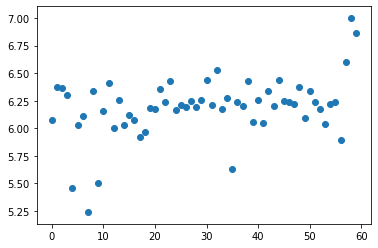

In [102]:
#plots
shop_item_price = features.groupby('shop_id_me')[['item_price_log']].agg(np.mean).reset_index()
plt.scatter(shop_item_price['shop_id_me'], shop_item_price['item_price_log'])
del shop_item_price

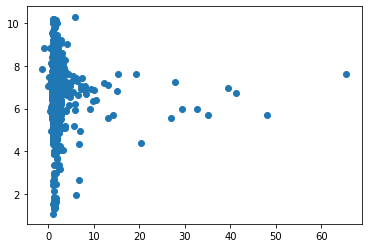

In [103]:
item_item_price = features.groupby('item_id_me')[['item_price_log']].agg(np.mean).reset_index()
plt.scatter(item_item_price['item_id_me'], item_item_price['item_price_log'])
del item_item_price

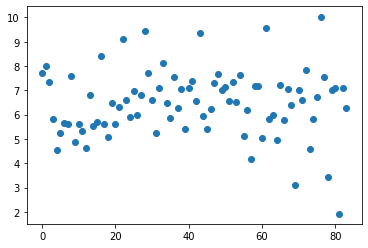

In [104]:
item_cat_item_price = features.groupby('item_cat_id_me')[['item_price_log']].agg(np.mean).reset_index()
plt.scatter(item_cat_item_price['item_cat_id_me'], item_cat_item_price['item_price_log'])
del item_cat_item_price

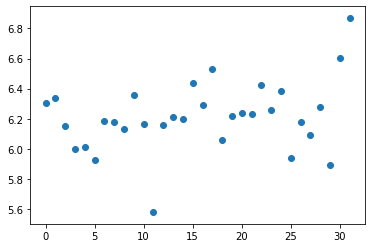

In [105]:
shop_cat_item_price = features.groupby('shop_cat_id_me')[['item_price_log']].agg(np.mean).reset_index()
plt.scatter(shop_cat_item_price['shop_cat_id_me'], shop_cat_item_price['item_price_log'])
del shop_cat_item_price

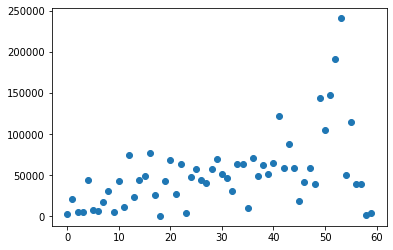

In [106]:
shop_id_me_num_shop = features.groupby('shop_id_me')[['num_shop']].agg(np.mean).reset_index()
plt.scatter(shop_id_me_num_shop['shop_id_me'], shop_id_me_num_shop['num_shop'])
del shop_id_me_num_shop

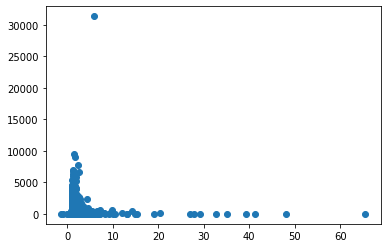

In [107]:
item_id_me_num_item = features.groupby('item_id_me')[['num_item']].agg(np.mean).reset_index()
plt.scatter(item_id_me_num_item['item_id_me'], item_id_me_num_item['num_item'])
del item_id_me_num_item

In [111]:
features = features.drop(['shop_id', 'item_id', 'shop_name', 'item_name', 'item_category_name','item_category_id', 'shop_category', 'item_price'], axis=1)
features.to_csv('features.csv', index=False)

In [113]:
X = features.iloc[:len(y), :]
X_sub = features.iloc[len(X):, :]

In [ ]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)


# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, l1_ratio=e_l1ratio))
                                        
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
                                   

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )
                                       

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)
                                

print('TEST score on CV')

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )



TEST score on CV
Kernel Ridge score: 2.3910 (0.7717)
 2020-01-19 19:09:16.438246
Lasso score: 2.3910 (0.7717)
 2020-01-19 19:11:58.474406
ElasticNet score: 2.3910 (0.7717)
 2020-01-19 19:27:55.089889
